# Twitter Topic Modeling with Non-negative Matrix Factorization

###### Ignacio Antequera Sanchez

*Content/Trigger Warning: This project uses real-world data from Twitter, but that comes at the risk of our dataset containing tweets about sensitive or triggering topics. This project should be approached without having to dig into the tweets present and reading about content*

# 0. Introduction
---
Hello Everyone!

My name is Ignacio Antequera Sanchez and in this project I will use the techniques for recommender systems in an unexpected way to help us model topics found on Twitter. Throughout this project, I will practice extracting topics from tweets using matrix factorization. This method assumes every tweet is a combination of several topics weighted by their prevailance in the text. This approach in fact finds a low-dimensional representation of the tweets (through the topic weights).

For this project, we will be working with tweets about the pandemic 2020 when the pandemic entered our lives. The dataset is obtained from [Kaggle](https://www.kaggle.com/smid80/coronavirus-covid19-tweets-late-april?select=2020-04-30+Coronavirus+Tweets.CSV) and the preprocessing we have done followed the steps [here](https://www.kaggle.com/satanizer/covid-19-tweets-analysis). For computational speed we will first analyze a dataset from one day: April 30, 2020. I encourage you to explore this dataset further and see how topics change over time. I might include some additional analysis from other different days in the future and study how topics change over time

Without further ado, let's delve into the data!

---

# 1. The Data
---
*Extracted from [Kaggle](https://www.kaggle.com/smid80/coronavirus-covid19-tweets-late-april?select=2020-04-30+Coronavirus+Tweets.CSV)*

First let's read the dataset into a data frame and have a look what is there.

In [1]:
import numpy as np
import pandas as pd

text = pd.read_csv('tweets-2020-4-30-1.csv')
text = text.fillna('') # some rows are nan so replace with empty string
text.tail()

np.random.seed(416)

## Note: Some preprocessing

The dataset you have just loaded was actually pre-processed by me in a different project. Here I briefly describe the steps handled already just so you know that there are usually some extra things that need to be done with text data. The code is also presented below.

* Removed tweets not in English. This is a tricky modeling choice, but one that is pretty common for simplicity and accuracy. Like when discussing bias, a better choice would probably to build up separate models for each language. 
* Removed URLs from tweets (not relevant to analysis)
* Make all text lower-case
* Remove all punctuation
* Remove stop-words (e.g., "a", "the", "to") using [NLTK](https://www.nltk.org/).
* Also remove some too frequent terms related to COVID that end up skewing the analysis.

The code for these steps is shown below. The original dataset had extra columns other than just text.

```
# select tweets in English
text = data['text'][data['lang']=='en']

# remove URL links
text = text.apply(lambda x: re.sub(r"https\S+", "", str(x)))

# make lower case
text = text.str.lower()

# remove punctuation
text = text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# remove stopwords and common COVID terms
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', 
                   '#coronavirusPandemic', '#covid19', '#covid_19', 
                   '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 
                   'covid19','covid-19', 'covidー19'])

def remove_stopwords(tweet):
    words = tweet.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)  # Trick to make string separated by spaces

text = text.apply(remove_stopwords)
```

## TF-IDF Matrix

Remember that matrix factorization methods work on matrices of numbers not text so we need to convert the text into a meaningful numeric representation.

Frequency-Inverse Document Frequency is a good way to do this since it defines a word weight vector for each document by accounting for the most popular words such as `the` or `a`.  We can extract it using `scikit-learn`.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create TF-IDF matrix
vectorizer = TfidfVectorizer(max_df=0.95)  # ignore words with very high doc frequency
tf_idf = vectorizer.fit_transform(text['text'])

# extract feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()

# check out the shape
print("TF-IDF matrix shape:", tf_idf.shape)

TF-IDF matrix shape: (119147, 183012)


It indicates that the TF-IDF matrix has a shape of (119147, 183012), which means there are 119,147 documents (tweets) in the dataset, and 183,012 unique words (features) in the vocabulary after preprocessing and applying the TF-IDF transformation.

This TF-IDF matrix will serve as the input for further analysis.

We will now make two variables `num_tweets` and `num_words` that store the number of tweets in our dataset and number of words in our analysis respectively.

In [3]:
# Calculate the number of tweets
num_tweets = tf_idf.shape[0]

# Calculate the number of words (features)
num_words = tf_idf.shape[1]

# Print the results
print("Number of Tweets:", num_tweets)
print("Number of Words (Features):", num_words)

Number of Tweets: 119147
Number of Words (Features): 183012


This confirms that there are 119,147 tweets in the dataset and 183,012 unique words (features) in the TF-IDF analysis.

# 2. Modeling Tweets with Topics
---
We will use a particular technique similar to matrix factorization for recommendation to help us model tweets. In particular we will use a model called Non-negative Matrix Decomposition to help us discover topics.

You might be wondering how we can use an approach we taught for recommender systems to model tweets, when there is no notion of recommending a tweet. The idea is to try to create two matrices to describe "Tweet factors" and "Word factors" that will hopefully correspond to distinct topics of discussion. Just like with matrix factorization for recommendation, our hope is that each factor corresponds to a topic.

We will use the [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) method from `scikit-learn` to extract the topics. 

We will set up an NMF model with 5 components and fit it to our TF-IDF data. Then, use the `fit_transform` to both fit the NMF model and transform our tweet data in one step.

When creating the model, we will use the following hyperparameters:
* `init='nndsvd'`
* `n_components=5`

When fitting the model, we will fit it on our TF-IDF data which is a matrix of the shape `(num_tweets, num_words)`.

Once we have done this, we will save our model in a variable called `nmf` and the projected tweets in a variable called `tweets_projected`.

In [4]:
from sklearn.decomposition import NMF

# Initialize NMF model with 5 components
nmf = NMF(n_components=5, init='nndsvd', random_state=42)

# Fit NMF model to TF-IDF data (tweets)
tweets_projected = nmf.fit_transform(tf_idf)

# Print the shape of the projected tweets matrix
print("Shape of projected tweets matrix:", tweets_projected.shape)

Shape of projected tweets matrix: (119147, 5)


### Inspecting Components

The topics are stored within the object `nmf.components_`. Let's investigate this matrix and the `tweets_projected` matrices by printing their values and their shapes.

In [5]:
# Print the shapes of nmf.components_ and tweets_projected
print("Shape of nmf.components_:", nmf.components_.shape)
print("Shape of tweets_projected:", tweets_projected.shape)

Shape of nmf.components_: (5, 183012)
Shape of tweets_projected: (119147, 5)


- The nmf.components_ matrix has a shape of (5, 183012), indicating that there are 5 topics (or "Word factors") represented by 183,012 unique words (features) in the TF-IDF analysis.
- The tweets_projected matrix has a shape of (119147, 5), indicating that there are 119,147 tweets represented by 5 components (or "Tweet factors") corresponding to the topics extracted by the NMF model.

The nmf.components_ field corresponds to the "Word factors" in the terminology of matrix factorization. This matrix represents the topics as combinations of words (features) found in the dataset. Therefore, it characterizes the contribution of each word to each topic, rather than the representation of each tweet in terms of topics.

# 3. Analyzing Topics
---
We are now interested in inspecting each topic to find the most prevelant or meaningful words for that topic. We'll consider the words with the highest weights for a topic in NMF model to be the most important words for that topic. Recall that the words themselves are stored in a variable called `feature_names`.

Before trying to investigate the values in the real data, let's do a small example first to explore how this can be done. We can use the [`argsort()`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) to get a list of array indices sorted by the values at those indices; this is useful when you want to use the ordered indices for another purpose.

In [6]:
# Given data
small_words = ['dogs', 'cats', 'axolotl']
small_weights = np.array([1, 4, 2])

# Sort the indices based on weights in descending order
sorted_indices = np.argsort(small_weights)[::-1]

# Use take_along_axis to get the sorted words array
sorted_small_words = np.take_along_axis(np.array(small_words), sorted_indices, axis=None).tolist()

# Print the sorted words array
print("Sorted Small Words:", sorted_small_words)

Sorted Small Words: ['cats', 'axolotl', 'dogs']


We will now generalize this code for the last section to work on our real dataset.

Ww will noe write a function `words_from_topic` to extract an ordered list of words in a topic (highest weight first).

In [7]:
def words_from_topic(topic, feature_names):
    """
    Sorts the words by their weight in the given topic from largest to smallest.
    
    Args:
        topic (np.array): A numpy array with one entry per word that shows the weight in this topic.
        feature_names (list): A list of words that each entry in topic corresponds to
    
    Returns:
        A list of words in feature_names sorted by weight in topic from largest to smallest. 
    """

    # Sort the indices based on weights in descending order
    sorted_indices = np.argsort(topic)[::-1]

    # Use sorted indices to rearrange words in feature_names
    sorted_feature_names = np.array(feature_names)[sorted_indices]

    # Convert the sorted numpy array back to a Python list and return
    return sorted_feature_names.tolist()

Once We have implemented the function above,  We should be able to run the cell below that uses our function to print out the top 10 words in each topic.

In [8]:
def print_top_words(components, feature_names, n_top_words):
    """Print the first n_top_words for each topic in components.

    Args:
        components (numpy.ndarray): NMF components matrix.
        feature_names (list): List of feature names (words).
        n_top_words (int): Number of top words to print for each topic.
    """
    for topic_index, topic in enumerate(components):
        ordered_words = words_from_topic(topic, feature_names)
        top_words = ', '.join(ordered_words[:n_top_words])
        print(f'Topic: #{topic_index}: {top_words}')

# 4. Investigating Tweets
---
Next let's look at a specific tweet (index 40151) and the individual contributions of the topics. The cell below prints the text of the original tweet and then the value of the tweet after being transformed by our NMF.

In [9]:
index = 40151
print(text.iloc[index]['text'])
print(tweets_projected[index])

attention seattle shoppers grocery stores working hard keep employees customers safe part help slow spread ☑️ limit trips ☑️ respect special shopping hours ☑️ follow socialdistance guidance stores wegotthisseattle
[0.00825208 0.         0.02897575 0.         0.01537722]


The transformed tweet value represents the contributions of the tweet to each of the topics extracted by the NMF model. The value is a vector where each element corresponds to a topic, and the magnitude of each element indicates the contribution of the tweet to that topic.

Here's the breakdown of the transformed tweet value:

- Topic 1: 0.00825208
- Topic 2: 0.0
- Topic 3: 0.02897575
- Topic 4: 0.0
- Topic 5: 0.01537722

Each value represents the contribution of the tweet to the respective topic. Since some values are zero, it indicates that the tweet has no significant contribution to those topics.

Based on the topic values for the tweet provided, The tweet is most associated with Topic #2 because it has the highest value among all topics. Therefore, Topic #2 is the topic that the tweet is most associated with based on the given topic values.

---

In our analysis above where we modeled each tweet in 5 topics, which topic has the most tweets strongly associated with it? 

For each tweet, We are now going to calculate which topic it is most strongly associated with by looking at the topic values for the tweet. If there is ever a tie for the largest topic weight, we will take the one with the lowest index (although this is unlikely to happen in our dataset).

We will save the index of the topic with the most tweets strongly associated with it in a variable called `largest_topic`. The result should be an integer for the index of the largest topic.

In [10]:
# Initialize an array to store the index of the largest topic for each tweet
largest_topic_indices = np.zeros(len(tweets_projected))

# Iterate over each tweet to find the index of the largest topic
for i in range(len(tweets_projected)):
    # Find the index of the largest element in the current tweet's topic values
    largest_topic_indices[i] = np.argmax(tweets_projected[i])

# Count the occurrences of each topic index
topic_counts = np.bincount(largest_topic_indices.astype(int))

# Find the index of the largest topic with the maximum count
largest_topic_index = np.argmax(topic_counts)

# Print the index of the largest topic
print("Index of the largest topic:", largest_topic_index)

Index of the largest topic: 4


The index of the largest topic is indeed 4, indicating that Topic #4 has the most tweets strongly associated with it based on the analysis of the transformed tweet values.

# 5. Investigating Trends
---

One benefit of using matrix factorization to a small dimension is that it lets us visualize tweets in this "topic space" to find any interesting groupings. 

In our earlier analysis we modeled each tweet as 5 topics but that is hard to visualize. 

We will now make a new NMF model and projected tweets (called `nmf_small` and `tweets_projected_small` respectively) with 3 components instead of 5 using the same settings for the other parameters as we did earlier.

In [11]:
# Create an NMF model with 3 components and initialize it using 'nndsvd'
nmf_small = NMF(n_components=3, init='nndsvd', random_state=42)

# Fit the NMF model to the TF-IDF data and simultaneously transform the data
tweets_projected_small = nmf_small.fit_transform(tf_idf)

We can explore the topics in this smaller model. Notably, they appear largely consistent, although a few topics had to be merged.

In [12]:
print_top_words(nmf_small.components_, feature_names, 10)

Topic: #0: us, people, pandemic, lockdown, need, get, health, time, home, like
Topic: #1: cases, new, deaths, total, confirmed, reported, number, positive, reports, today
Topic: #2: help, spread, app, selfreporting, symptoms, download, sooner, identify, slow, feel


This function call prints the top 10 words for each topic in the smaller NMF model using the print_top_words function that we defined earlier. Now that we have 3 values for each tweet, we can actually plot each tweet in 3D space to see how all the tweets relate to each other.

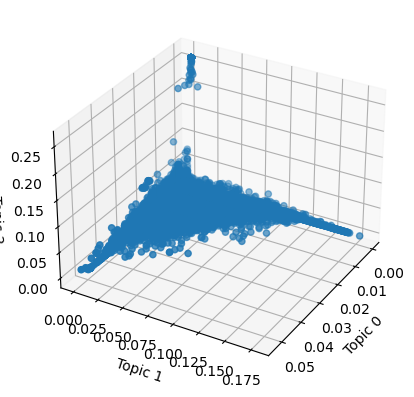

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Extract the three topic values for each tweet
x = tweets_projected_small[:, 0]
y = tweets_projected_small[:, 1]
z = tweets_projected_small[:, 2]

# Plot the 3D scatterplot
ax.scatter(x, y, z)

# Set axis labels
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')

# Rotate the plot for better viewing
ax.view_init(30, 30)

# Show the plot
plt.show()

Interesting, it looks like there is a small cluster of Tweets that are far away from all the others when looking at Topic 2. In other words, there are a few tweets that are very far in the Topic 2 direction while the majority of tweets are spread out more in Topic 0/1.

# 6. Outlier Tweets
---
Let's look into the tweets that seem very different than the rest. 

For this problem, we want you to compute all of the unique tweets (since there are some duplicates) that appear in this region in the "topic space". 

For this problem, we should follow these steps:
1. Find the which rows in our `tweets_projected_small` our outliers. We will define this tweets as ones that have a value of `0.15` or more for Topic 2.
2. Now that we know which rows are outliers, we will use that information to access the `text` column of our original tweets `DataFrame` `text` for those rows.
3. Use the `.unique` function available on a column of a `pandas` `DataFrame`to find all the unique values.

In [14]:
# Initialize arrays z and y with zeros
z = y = np.zeros(len(tweets_projected_small[:, 2]))

# Populate z with outlier indices based on Topic 2 value threshold
z = np.where(tweets_projected_small[:, 2] >= 0.15, y, -1)

# Find unique outlier indices and remove -1 (non-outliers)
rows = np.delete(np.unique(z, return_counts=True)[0], 0)

# Extract outlier tweet texts based on unique outlier indices
outlier_tweets = np.empty(len(rows), dtype=object)
for i, row in enumerate(rows):
    outlier_tweets[i] = text.iloc[int(row)]['text']

# Find unique outlier tweet texts
outlier_tweets = np.unique(outlier_tweets)

# Print the number of unique outlier tweets and a sample
print("Number of unique outlier tweets:", len(outlier_tweets))
print("Sample of unique outlier tweets:")
for tweet in outlier_tweets[:10]:
    print("-", tweet)

Number of unique outlier tweets: 1
Sample of unique outlier tweets:
- event 202 april 30th 5pm uk time via youtube interesting virtual meeting discussion people around world uk usa canada israel etc live


Based on the output provided, it appears that there is only one unique outlier tweet identified by the model. The sample outlier tweet mentions an "event" scheduled for April 30th at 5pm UK time, with a discussion involving people from various locations around the world.

The theme among these tweets appears to be related to virtual events or discussions occurring on April 30th, involving participants from different geographical regions.

As for why our model isolated this tweet as an outlier or assigned it to its own topic, there could be several reasons:

- Distinctive Content: The content of this tweet may contain unique or specific keywords, phrases, or topics that are not prevalent or strongly associated with the majority of tweets in the dataset.
- Uncommon Topic: The event mentioned in the tweet may be a niche or specialized topic that is not widely represented in the rest of the dataset, leading the model to isolate it as a separate topic.
- Geographical Variation: The involvement of participants from various locations around the world may introduce diversity or variability in the content of the tweet, making it stand out from the rest of the tweets in terms of topic distribution.

Overall, the model may have identified this tweet as an outlier or assigned it to its own topic due to its unique content, specialized topic, or distinct characteristics compared to the majority of tweets in the dataset.

# 7. Reflection & Final Comments
---

This project focused on analyzing topics in Twitter data related to the pandemic using Non-negative Matrix Factorization (NMF). Throughout the project, various tools and methods were utilized to preprocess the data, extract topics, visualize the results, and identify outliers. Here's a summary of the key points:

1. Data Preprocessing: The project started with loading and preprocessing the Twitter dataset, including steps like removing non-English tweets, URLs, punctuation, and stop words. This ensured that the text data was clean and ready for analysis.
2. Topic Modeling with NMF: Non-negative Matrix Factorization (NMF) was used to extract topics from the preprocessed Twitter data. The TF-IDF matrix was generated to represent the text data numerically, and NMF was applied to identify latent topics within the tweets.
3. Visualization: The results of the topic modeling were visualized using techniques like 3D scatter plots to understand the distribution of tweets in the topic space. This provided insights into how tweets clustered based on different topics.
4. Identifying Outliers: Outlier tweets were identified based on their projections in the topic space, and unique outlier tweets were extracted from the dataset. These outlier tweets represented distinct topics or discussions compared to the majority of tweets.
5. Tools and Methods: The project utilized Python libraries such as NumPy, Pandas, Matplotlib, and Plotly for data manipulation, analysis, and visualization. Non-negative Matrix Factorization (NMF) was employed as the primary method for topic modeling.
6. Understanding of Machine Learning Concepts: This project helped reinforce several machine learning concepts, including data preprocessing techniques, topic modeling with NMF, visualization of high-dimensional data, and outlier detection. It provided practical experience in applying these concepts to real-world data analysis tasks.

Overall, this project served as a valuable learning experience in exploring and analyzing text data from social media using machine learning techniques. It enhanced my understanding of data preprocessing, topic modeling, visualization, and outlier detection, and provided insights into the application of these techniques in real-world scenarios.

Through this project, I gained hands-on experience in working with textual data, applying machine learning algorithms, and interpreting the results. It further solidified my understanding of the importance of preprocessing, feature engineering, and visualization in the machine learning workflow.

Moving forward, I aim to continue exploring different machine learning algorithms, techniques, and applications to further enhance my skills and understanding in the field.

Overall, this project was instrumental in deepening my understanding of machine learning concepts and their practical application to real-world data analysis tasks.

Kindly find my contact details listed below for your convenience. Your input is greatly appreciated.

Ignacio Antequera Sanchez

***

[LinkedIn](https://www.linkedin.com/in/ignacio-antequera)  ||  [GitHub](https://github.com/Ignacio-Antequera)  ||  [Leetcode](https://leetcode.com/Ignacio_antequera)